In [31]:
import time
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.action_chains import ActionChains
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import requests
from array import array
import os
import sys
import time
from io import BytesIO
import json

In [9]:
option = webdriver.ChromeOptions()
option.add_argument("-incognito")
#option.add_experimental_option("excludeSwitches", ['enable-automation']);
#option.add_argument("--headless")
#option.add_argument("disable-gpu");
browser = webdriver.Chrome(executable_path=r'/home/srujandeshpande/chromedriver', options=option)

In [10]:
subscription_key = os.environ['OCR_SUBSCRIPTION_KEY']
endpoint = os.environ['OCR_ENDPOINT']

In [33]:
browser.get("https://vahan.nic.in/nrservices/faces/user/searchstatus.xhtml")

In [34]:
browser.save_screenshot("image.png") 
 
image = Image.open("image.png") 
 
#image.show() 

In [35]:
e = browser.find_element_by_xpath('//*[@id="capatcha"]/img')

location = dict(e.location)
size = dict(e.size)
print(location,size)

{'x': 766, 'y': 217} {'height': 30, 'width': 150}


In [36]:
im = Image.open("image.png") 

# Size of the image in pixels (size of orginal image) 
# (This is not mandatory) 
width, height = im.size 
  
# Setting the points for cropped image 
left = location['x']
top = location['y']-10
right = location['x']+size['width']
bottom = location['y']+size['height']+10
  
# Cropped image of above dimension 
# (It will not change orginal image) 
im1 = im.crop((left, top, right, bottom)) 
  
# Shows the image in image viewer 
im1.show() 
im1.save("cropped.png")

In [37]:
ocr_url = endpoint + "vision/v3.0/read/analyze"

image_data = open("cropped.png", "rb").read()

headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}

params = {'language': 'en'}

response = requests.post(ocr_url, headers=headers, params=params, data=image_data)

response.raise_for_status()

#response.json()

In [38]:
result = dict()

analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()
    
    result = json.dumps(analysis, indent=4)

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False


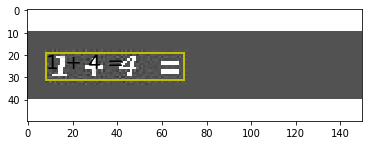

In [39]:
polygons = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]

# Display the image and overlay it with the extracted text.
image = Image.open("cropped.png")
ax = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
                for i in range(0, len(polygon[0]), 2)]
    text = polygon[1]
    patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")
plt.show()